In [ ]:
# import numpy as np                                                                        
# import matplotlib.pyplot as plt
# import pyCloudy as pc
# import pyneb as pn
# from astropy    import constants as const
# from astropy.io import ascii
# import pandas as pd
# from scipy import interpolate
# import warnings
# from scipy.integrate import quad, IntegrationWarning
# # from scipy.integrate import simps
# from numpy import log10, exp

# kpc = const.kpc.cgs.value

# atom = ['Lya','HeII','CIV']

# def read_file(path_way, atom):
#     Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
#     Mod.ionic_names

#     N_H = sum(Mod.dr*Mod.nH)
#     # solar_metallicitiy from von Steiger et al. 2016
#     frac_He = 1.0E-01
#     frac_C = 4.47E-04
#     frac_O = 6.61E-04
#     frac_N = 9.33E-05
#     frac_Mg = 7.08E-05

#     N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
#     N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
#     N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
#     N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
#     N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
#     N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

#     num = len(Mod.nH)
#     r_CIV = path_way +  '.ele_C'
#     f = open(r_CIV,'r')
#     header = f.readline()
#     CIV_frac = np.zeros(num)
#     i = 0
#     for line in f:
#         line = line.strip()
#         columns = line.split()
#         j = float(columns[4])
#         CIV_frac[i] = j
#         i = i + 1

#     r_He = path_way +  '.ele_He'
#     f = open(r_He,'r')
#     header = f.readline()
#     HeII_frac = np.zeros(num)
#     i = 0
#     for line in f:
#         line = line.strip()
#         columns = line.split()
#         j = float(columns[2])
#         HeII_frac[i] = j
#         i = i + 1



#     n_H= Mod.nH
#     n_He = n_H*frac_He
#     n_C = n_H*frac_C
#     nden_CIV = CIV_frac*n_C
#     nden_HeII = HeII_frac*n_He

#     # tt = nden_CIV / n_H
#     # print(tt.mean())

#     if atom == 'CIV':
#         Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
#         Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
#         Cloudy_den = nden_CIV
#     elif atom == 'Lya':
#         Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
#         Cloudy_emis = Mod.get_emis('H__1_121567A')
#         Cloudy_den = n_H
#     elif atom == 'HeII':
#         Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
#         Cloudy_emis = Mod.get_emis('HE_2_164043A')
#         Cloudy_den = nden_HeII
#     return Cloudy_Lum , Cloudy_emis ,Cloudy_den

# def radius(path, atom):
#     Mod = pc.CloudyModel(path, cloudy_version_major=23)
#     radius = Mod.radius/kpc
#     radius_kpc =Mod.radius 
#     dr = Mod.dr 
#     return radius, radius_kpc, dr

# def make_data_file(path,atom):
#     lum ,emis ,den = read_file(path,atom)
#     radius_R , radius_kpc , dr=  radius(path,atom)
#     tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
#     tt.to_csv('/home/jin/T_Cloudy/{}_cloudy.txt'.format(atom), sep='\t',index=False,header =False)
#     # tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
#     return print("make data file!")

# def SB(z,radius_kpc, emissivity):
#     r_min, r_max = radius_kpc.min(), radius_kpc.max()       
#     Project_R = np.linspace(0, r_max, 100)
#     surface_brightness = np.zeros(len(Project_R))
#     Lumin = np.zeros(len(Project_R))
#     T_Lumin = np.zeros(len(Project_R))
    
#     for ii, bb in enumerate(Project_R[:-1]):
#         array_R = np.where(radius_kpc >= bb)[0]
#         r_surface_brightness = 0
#         for dR in (array_R[:-1]):
#             dr = radius_kpc[dR+1] - radius_kpc[dR]
#             r_surface_brightness += emissivity[dR] * dr
#         surface_brightness[ii] = 4*r_surface_brightness / (1+z)**4
#         dR_pro = Project_R[ii+1] -Project_R[ii] 
#         Lumin[ii] = 2*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

#     return Project_R, surface_brightness, Lumin

# def RT_SB(path):
#     name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
#     data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
#     rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
#     return rad/kpc, rad, SB_t 

# def find_y(x_find,x,y):
#     ii = int(np.where(x <= x_find)[0][-1])
#     # print(ii)
#     y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
#     return y_find

# warnings.filterwarnings("ignore", category=IntegrationWarning)

In [40]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
# from scipy.integrate import simps
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # tt = nden_CIV / n_H
    # print(tt.mean())

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/CIV_cloudy.txt', sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
    return print("make data file!")

def SB(z,radius_kpc, emissivity,dr ,rt_radius):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()  
    # N = len(rt_radius)     
    # Project_R = np.copy(rt_radius)
    Project_R  = np.linspace(0,100,80) * kpc
    N = len(Project_R )
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)
    T_Lumin = np.zeros(N)
    dR_pro = Project_R[1] -Project_R[0] 
    for ii, bb in enumerate(Project_R):
        array_R = np.where(radius_kpc >= bb)[0]
        r_surface_brightness = 0
        for dR in (array_R[:-1]):
            r_surface_brightness += emissivity[dR] * dr[dR] * radius_kpc[dR]**2
        if bb ==0 :
            bb = dR_pro
        surface_brightness[ii] = 4*r_surface_brightness / (1+z)**4 / bb**2
        Lumin[ii] = 2*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

    return Project_R/ kpc, surface_brightness, Lumin

def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

In [46]:
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42'
# make_data_file(path_LT ,'Lya')

In [77]:
#Ubuntu

path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42'

v_rand = ['11.8','50','100']
v_out =['0','200','400','500','600','800']
v_emit = ['1','50','100']

def RT_make_parameter(v_out,v_emit ,v_rand,atom):
    a,b,c = 0,0,0
    # e,f = 0 , 0
    if v_out == 0 :
        expand = "000"
        vout_order = 0
    else: 
        expand = v_out 
        vout_order = 2

        if v_emit == 1 :
            emit = int(v_emit*100)
            emit_order = 0
        elif v_emit > 1 and v_emit < 100:
            emit = int(v_emit*10)
            emit_order = 1          
        else : 
            emit = v_emit
            emit_order = 2

            if v_rand < 100:
                rand = int(v_rand * 10)
                rand_order = 1 
            else :
                rand = v_rand
                rand_order = 2 

    
                globals()['path_rt_{}_{}_{}'.format(v_out,v_emit,rand)] =  r'/home/jin/T_Cloudy/sb_cloudy/data_RT/N_atom000E+00_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}radi.dat'.format(expand, vout_order, emit,emit_order,rand,rand_order)
                globals()['rt_radius_{}_{}_{}'.format(v_out,v_emit,rand)] , globals()['rt_radius_kpc_{}_{}_{}'.format(v_out,v_emit,rand)], globals()['rt_sb_t_{}_{}_{}'.format(v_out,v_emit,rand)] = RT_SB(globals()['path_rt_{}_{}_{}'].format(v_out,v_emit,rand))
                # radius , radius_kpc, sb = RT_SB(globals()['path_rt_{}_{}_{}'].format(v_out,v_emit,rand))
                a, b ,c = globals()['rt_radius_{}_{}_{}'.format(v_out,v_emit,rand)] , globals()['rt_radius_kpc_{}_{}_{}'.format(v_out,v_emit,rand)], globals()['rt_sb_t_{}_{}_{}'.format(v_out,v_emit,rand)]
                print("make parameters of v_rand = {} km/s,  v_exp = {} km/s , and v_emit = {} km/s  ".format(v_out,v_emit,rand))

                # z_red_Shift = 0
                # globals()['radius_{}'.format(atom)] , globals()['radius_kpc_{}'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path_LT,atom)
                # globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path_LT,atom)
                # globals()['p_radius_{}'.format(atom)] , globals()['sb_{}'.format(atom)], globals()['lum_sb_{}'.format(atom)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)] , a )

        return a,b,c

# def CLOUDY_make_parameter(atom):
#     z_red_Shift = 0
#     globals()['radius_{}'.format(atom)] , globals()['radius_kpc_{}'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path_LT,atom)
#     globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path_LT,atom)
#     globals()['p_radius_{}'.format(atom)] , globals()['sb_{}'.format(atom)], globals()['lum_sb_{}'.format(atom)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)] , globals()['rt_radius_kpc_{}'.format(atom)])
#     return print("make parameters of {} ".format(atom))

In [153]:
import numpy as np  # np.sum 사용을 위해 필요

def calculate_order_and_value(value):
    """ 주어진 값에 대해 변환된 값과 해당 order 반환 """
    if value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    return value, 2

def RT_make_parameter(v_out, v_emit, v_rand, atom):
    # 기본값 설정
    radius_RT, radius_kpc_RT, SB_RT = np.array([0]), np.array([0]), np.array([0])
    radius_CL, sb_CL = np.array([0]), np.array([0])
    normal_RT, normal_CL = 1, 1  # ZeroDivisionError 방지

    if v_out == 0:
        expand, vout_order = "000", 0
    else:
        expand, vout_order = v_out, 2
    emit, emit_order = calculate_order_and_value(v_emit)
    rand, rand_order = calculate_order_and_value(v_rand)

    # 파일 경로 설정
    path_rt = (f'/home/jin/T_Cloudy/sb_cloudy/data_RT/N_atom000E+00_'
                f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
                f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')

    # RT_SB 함수 호출
    rt_output = RT_SB(path_rt)
    if rt_output is not None:
        radius_RT, radius_kpc_RT, SB_RT = rt_output

    # SB_RT 값이 None이거나 비어있을 경우 기본값 설정
    if SB_RT is None or len(SB_RT) == 0:
        SB_RT = np.array([0])
    normal_RT = np.sum(SB_RT) if np.sum(SB_RT) != 0 else 1

    print(f"make parameters of v_rand = {v_rand} km/s, v_exp = {v_out} km/s, v_emit = {v_emit} km/s")

    # 추가 데이터 처리
    z_red_Shift = 0
    radius_data = radius(path_LT, atom)
    lum_data = read_file(path_LT, atom)
    sb_data = SB(z_red_Shift, radius_data[1], lum_data[1], radius_data[2], radius_RT)

    if sb_data is not None:
        radius_CL, sb_CL = sb_data[0], sb_data[1]

    # sb_CL 값이 None이거나 비어있을 경우 기본값 설정
    if sb_CL is None or len(sb_CL) == 0:
        sb_CL = np.array([0])
    normal_CL = np.sum(sb_CL) if np.sum(sb_CL) != 0 else 1

    return radius_RT, radius_kpc_RT, SB_RT / normal_RT, radius_CL, sb_CL / normal_CL


In [180]:
# a,b,c ,e ,f =RT_make_parameter(200,50,11.8,'CIV')
a,b,c,e,f = RT_make_parameter(300,50,11.8,'CIV')


make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 50 km/s


(-0.5, 100.0)

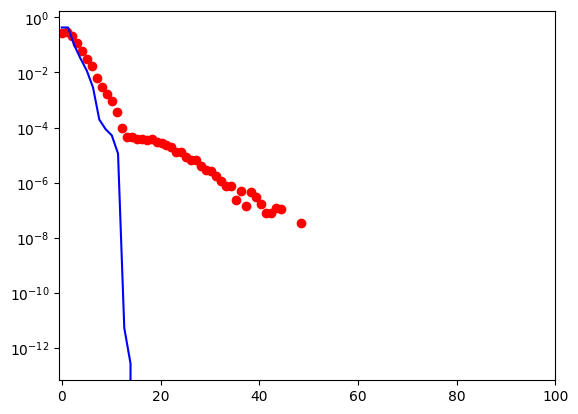

In [181]:
plt.plot(a,c,'ro')
plt.plot(e,f,'b-')

plt.yscale('log')
plt.xlim(-0.5,100)

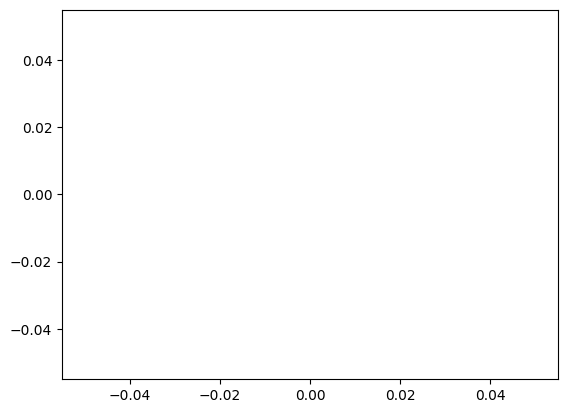

In [64]:
# plt.plot(RT_make_parameter(200,50,11.8)[0],RT_make_parameter(200,50,11.8)[2] )
# a,b,c=RT_make_parameter(200,50,11.8)
plt.plot(a,c)
# plt.plot(p_rad)

In [10]:
# path_radi =  '/home/jin/RT_code/data_CIV/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
# data_sp = pd.read_csv(path_radi, sep='\s+', header=None,names=name)

# rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()

# path_sc =  '/home/jin/RT_code/data_CIV/N_atom100E+01_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# data_sc = pd.read_csv(path_sc, sep='\s+', header=None,names=name)

# rad_sc, SB_t_sc, SB_k_sc,SB_h_sc =  data_sc['radius'].to_numpy(),data_sc['SB_tot'].to_numpy(),data_sc['SB_K'].to_numpy(),data_sc['SB_H'].to_numpy()


# z = 1 # z = 14 로 설정해야 R = 1kpc 에서 photoionization 이랑 RT-scat 결과의 SB가 같게 나옴.
# SB_z_civ =SB_civ / (1+z)**3 / SI_sr_to_arc
# SB_z_heii =SB_heii / (1+z)**3 / SI_sr_to_arc
# SB_z_lya =SB_lya / (1+z)**3 / SI_sr_to_arc

# fig = plt.figure(1,figsize=(21,7))
# plt.subplot(131)
# plt.plot(Rad_civ,SB_z_civ,'b-',label=r'CIV Photoionization at z = {:}'.format(z))
# plt.plot(Rad_heii,SB_z_heii,'r-',label='HeII')
# plt.plot(rad/kpc,SB_t,'bs',mfc='None',alpha=0.5,label='RT-Scat w/o scattering')
# plt.plot(rad_sc/kpc,SB_t_sc,'bo',mfc='None',alpha=1,label='RT-Scat w scattering')

# plt.axvline(x=1,color='k',linestyle='--')
# plt.xlim(0.4,5)
# plt.ylim(1e-26,1e-11)
# plt.yscale('log')
# plt.xlabel('Radius [kpc]',fontsize=25)
# plt.ylabel(r'SB $\rm [erg/s/cm^{2}/arcsec^{2}]$',fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.minorticks_on()
# plt.grid(True)
# plt.legend(fontsize=15)


# plt.subplot(132)
# plt.plot(Rad_civ,SB_z_civ,'b-',label=r'CIV Photoionization at z = {:}'.format(z))
# plt.plot(Rad_heii,SB_z_heii,'r-',label='HeII')
# plt.plot(rad/kpc,SB_t,'bs',mfc='None',alpha=0.5,label='RT-Scat w/o scattering')
# plt.plot(rad_sc/kpc,SB_t_sc,'bo',mfc='None',alpha=1,label='RT-Scat w scattering')
# plt.axvline(x=7, color='g',linestyle='--')
# plt.axvline(x=1,color='k',linestyle='--')
# plt.xlim(0.4,25)
# plt.ylim(1e-26,1e-11)
# plt.yscale('log')
# plt.xlabel('Radius [kpc]',fontsize=25)
# plt.ylabel(r'SB $\rm [erg/s/cm^{2}/arcsec^{2}]$',fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.minorticks_on()
# plt.grid(True)
# plt.legend(fontsize=15)



# plt.subplot(133)
# plt.plot(Rad_civ,SB_z_civ,'b-',label=r'CIV Photoionization at z = {:}'.format(z))
# plt.plot(Rad_heii,SB_z_heii,'r-',label='HeII')
# plt.plot(rad/kpc,SB_t,'bs',mfc='None',alpha=0.5,label='RT-Scat w/o scattering')
# plt.plot(rad_sc/kpc,SB_t_sc,'bo',mfc='None',alpha=1,label='RT-Scat w scattering')
# plt.axvline(x=7, color='g',linestyle='--')
# plt.axvline(x=1,color='k',linestyle='--')
# plt.xlim(0.4,100)
# plt.ylim(1e-26,1e-11)
# plt.yscale('log')
# plt.xlabel('Radius [kpc]',fontsize=25)
# plt.ylabel(r'SB $\rm [erg/s/cm^{2}/arcsec^{2}]$',fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.minorticks_on()
# plt.grid(True)
# plt.legend(fontsize=15)

# plt.tight_layout()
# plt.savefig('/home/jin/바탕화면/CIV_RT_Scat_Result.pdf',dpi=100)